## Bibliothèques

In [300]:
import numpy as np
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import random as rd
from tqdm import tqdm

## Données

In [152]:
def generate_toy_data(a, gamma, nbex):
    # a donne les coefficients pour la regression, b le biais
    X = 10 * np.random.random((nbex, len(a)))
    noise = np.random.normal(0, np.sqrt(1 / gamma), nbex)
    a = np.array(a).reshape(len(a), 1)
    Y = np.dot(X, a) + noise.reshape(nbex, 1)
    return X, Y

In [123]:
def traitement(data_init):
    n, m = np.shape(data_init)
    result = np.zeros((0,m))
    for i in range(n):
        string = "?"
        if string not in data_init[i,:] and data_init[i, 1] == "R":
            result = np.vstack((result, data_init[i,:]))
    result = result[:, 2:]
    result = np.array(result, dtype = float)
    return result

# Simulation d'avis

In [213]:
def annotations_estim(values, lmbs):
    annotations_nb = lmbs.shape[0]
    values = np.repeat(values.reshape((-1, 1)), annotations_nb, axis = 1)
    noise = np.random.normal(0, np.sqrt(1 / lmbs), (values.shape[0], annotations_nb))
    return values + noise

# Implémentation

In [135]:
def lambda_vect(w, data, annotations):
    sim_values = np.repeat(w.dot(data.T).reshape((-1, 1)), annotations.shape[1], axis = 1)
    diff = annotations - sim_values
    lambdas = np.sum(diff**2, axis = 0) / data.shape[0]
    return 1 / lambdas
    
def w_vect(lambdas, data, annotations):
    first_term = data.T.dot(data)
    second_term = data.T.dot(annotations.dot(lambdas) / np.sum(lambdas))
    return np.linalg.inv(first_term).dot(second_term)

In [127]:
def log_likelihood(w, lmbs, data, annotations):
    log_lklhd = 0
    for j in range(annotations.shape[1]):
        log_lklhd += np.sum(0.5 * (np.log((lmbs[j]**2) / (2 * np.pi)) - (lmbs[j] * (annotations[:, j] - data.dot(w)))**2))
    return log_lklhd

In [249]:
def MLE_algorithm(data, annotations, winit, max_iter = 20, print_lklhd = False):
    lmbs = lambda_vect(winit, data, annotations)
    for ite in range(max_iter):
        w = w_vect(lmbs, data, annotations)
        lmbs = lambda_vect(w, data, annotations)
        if print_lklhd and ite%5 == 1:
            print(log_likelihood(w, lmbs, data, annotations))
    return w, lmbs

# Test sur données artificielles

In [242]:
# Generation des donnees artificielles pour test de l'algorithme

toy_w = np.array([-0.5, 3, 1.4, 1, -2])
toy_gamma = 2
sample_nb = 2000
toy_data, toy_values = generate_toy_data(w, toy_gamma, sample_nb)

# Generation d'avis pour les donnees artificielles

toy_taus = np.array([2, 1, 0.5])
toy_annotations = annotations_estim(toy_values, toy_taus)

In [245]:
winit = np.random.random(5)
sim_toy_w, sim_toy_lmbs = MLE_algorithm(toy_data, toy_annotations, winit, print_lklhd = False)

print("w artificiel : ", toy_w)
print("w simulé : ", sim_toy_w)
print("lambda artificiel : ", (toy_taus * toy_gamma) / (toy_taus + toy_gamma))
print("lambda simulé : ", sim_toy_lmbs)

w artificiel :  [-0.5  3.   1.4  1.  -2. ]
w simulé :  [-0.49662406  2.998302    1.40701616  0.98920259 -1.99728412]
lambda artificiel :  [ 1.          0.66666667  0.4       ]
lambda simulé :  [ 1.00228426  0.65789697  0.38115328]


# Test sur données réelles

In [306]:
# Chargement des donnees, on ne garde que les cas de retour de cancer

data_init = pd.read_csv("data_prognostic.data",header=None)
data_init = np.array(data_init)
clean_data = traitement(data_init)

data = clean_data[:, 1:]
rec_time = clean_data[:, 0]

print("Nombre de cas : ", clean_data.shape[0])
print("Nombre de variables : ", clean_data.shape[1])

# Generation d'avis pour les donnees reellles

taus = np.array([0.01, 1, 0.1])
annotations = annotations_estim(rec_time, taus)

Nombre de cas :  46
Nombre de variables :  33


In [295]:
# Regression lineaire sur les donnees par moindre carre pour estimer w puis gamma

real_w = np.linalg.inv(data.T.dot(data)).dot(data.T).dot(rec_time)
real_noise = real_w.dot(data.T) - rec_time
real_gamma = 1 / real_noise.var()

print("inverse de la variance (gamma) : ", real_gamma)

inverse de la variance (gamma) :  0.0103115871259


w reelle :  [  4.48174008e+01   7.37740006e-01  -7.31973132e+00   1.69471654e-01
   3.06003495e+03   8.16022643e+01   1.33311351e+03  -2.63152910e+03
   6.37024747e+02  -6.88602710e+03  -3.56838003e+02  -2.24391176e+01
   9.70467528e+01  -1.70793063e+00  -5.35514606e+03  -4.64558387e+02
  -1.54804256e+03   4.12742176e+03   1.11616200e+03  -7.60663619e+03
   1.97745870e+01   4.42016862e-01  -5.36985080e+00   7.64584817e-02
   7.71643953e+02  -3.31863165e+01  -1.03319909e+02  -3.55970732e+02
  -2.80514847e+02   2.45553835e+03   8.33412201e-01   2.17809287e-01]
w simulé :  [  5.92231290e+01   2.34018944e-01  -8.94467543e+00   1.45130555e-01
   2.91112987e+03   4.40757317e+01   1.31599616e+03  -2.51982310e+03
   6.63723770e+02  -6.72637064e+03  -3.50470646e+02  -2.47556368e+01
   9.88136333e+01  -1.75632860e+00  -5.28549806e+03  -5.81885950e+02
  -1.48037828e+03   3.43471494e+03   1.02402519e+03  -5.29831652e+03
   1.74647725e+01   6.69153938e-01  -5.45473013e+00   8.87309863e-02
   8.1032

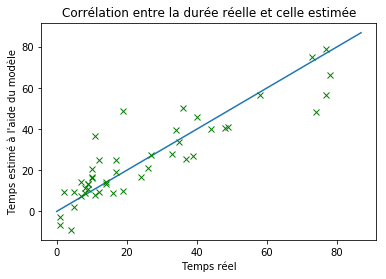

In [304]:
winit = np.random.random(data.shape[1])
sim_w, sim_lmbs = MLE_algorithm(data, annotations, winit, print_lklhd = False)

print("w reelle : ", real_w)
print("w simulé : ", sim_w)
print("lambda reel : ", (taus * real_gamma) / (taus + real_gamma))
print("lambda simulé : ", sim_lmbs)

print("Coefficient de corrélation pour w : ", pearsonr(real_w, sim_w)[0])
print("Coefficient de corrélation pour la prédiction : ", pearsonr(rec_time, sim_w.dot(data.T))[0])

plt.figure()
plt.plot(range(0, int(np.max(rec_time)) + 10), range(0, int(np.max(rec_time)) + 10))
plt.plot(rec_time, sim_w.dot(data.T), "gx")
plt.title("Corrélation entre la durée réelle et celle estimée")
plt.xlabel("Temps réel")
plt.ylabel("Temps estimé à l'aide du modèle")